# log 보고 파싱하는 루틴

- Building model로 뭉탱이씩 나누고
- 뭉땡이 안에서 Step [109/109]로 짤라서 그 밑에 줄부터 46번째 줄까지가 test에 대한 disagree 개수임. 뭉땡이 하나 안에는 50개의 step [109/109] 있음.

- 해당되는 disagree id를 : 로 split하면 뒤에가 ??/128 이니까 다시 ‘/’로 split해서 앞에 int 때리면 개수임
- 이거 다 더해서 128*46으로 나누면 됨(batch 128인데 안 나눠떨어지면 버림처리해서 실제보다 적은 수인거)
- 그래서 epoch에 따른 CNN+CNN 인 경우의 disagree 개수 , CNN+alpha인 경우의 disagree 개수 를 살펴보자.
    - 이게 epoch 20 전후로 뭔가 변하기 시작하는게 보이면 의미가 있다고 볼 수 있음
    - 혹시 진짜 disagree 떄문인거면 코드에서 init_epoch=2000으로 올리고 하면 coteaching+ 말고 그냥 coteaching으로 돌아가니까 그러고나서 내 모델이랑 coteaching 모델이랑 성능 비교해보면 될듯

In [1]:
import os

path = r'C:\Users\SHIN-DESKTOP\Documents\remote\diff_model_coteaching_plus\logs'
p1 = 'debug_20221213_cnn+alpha.log'
p2 = 'debug_20221214_lstm_fcn+alpha.log'

# 모델 별로 결과 분석해보기

In [8]:
cnn_alpha_result = os.path.join(path, p1)
with open(cnn_alpha_result, "r") as f:
    lines = f.readlines()

lstm_fcn_alpha_result = os.path.join(path, p2)
with open(lstm_fcn_alpha_result, "r") as f:
    lines2 = f.readlines()
lines.extend(lines2)

# Building model 로그로 각 실험별로 시작 위치 잘라내기
## 먼저 Building model 로그가 위치한 point 찾아서 저장
experiment_idx_points = []
for idx, l in enumerate(lines):
    if 'Building model' in l:
        experiment_idx_points.append(idx)

## 찾아낸 Building model 로그 위치를 통해 각 실험로그를
experiment_packs = []
for idx, ex in enumerate(experiment_idx_points):
    if idx == (len(experiment_idx_points)-1):
        experiment_packs.append( lines[experiment_idx_points[idx]:] )
    else:
        experiment_packs.append( lines[experiment_idx_points[idx]:experiment_idx_points[idx+1]] )

# 구한 개별 실험마다
step_packs = []
for ex_pck in experiment_packs:
    step_indices = []
    ## step으로 나눠서 test 결과 수집하기
    for idx, line in enumerate(ex_pck):
        if "Step [109/109]" in line:
            step_indices.append(idx)

    ## 각 test 결과에서 disagree number만 뽑아내기
    lst_tot_disagree = []
    for idx, step_index in enumerate(step_indices):
        tot_disagree = 0
        for l in ex_pck[step_index+1: step_index+46]:
            number = l.split(': ')[-1]
            number = number.split('/')[0]
            number = int(number)
            tot_disagree = tot_disagree + number
        tot_disagree = tot_disagree / (128*46)
        tot_disagree = round(tot_disagree, 4)
        lst_tot_disagree.append(tot_disagree)

    step_packs.append(lst_tot_disagree)

experiments_name_list = [
    ('TextCNN', 'TextCNN'), ('TextCNN', 'TextCNN'), ('TextCNN', 'TextCNN'),
    ('TextCNN', 'LSTM'), ('TextCNN', 'LSTM'), ('TextCNN', 'LSTM'),
    ('TextCNN', 'FCN'), ('TextCNN', 'FCN'), ('TextCNN', 'FCN'),
    ('LSTM', 'LSTM'), ('LSTM', 'LSTM'), ('LSTM', 'LSTM'),
    ('LSTM', 'FCN'), ('LSTM', 'FCN'), ('LSTM', 'FCN'),
    ('FCN', 'FCN'), ('FCN', 'FCN'), ('FCN', 'FCN')
]

total_logs = []
for i, item in enumerate(step_packs):
    #print(f'[{experiments_name_list[i][0]:^7} / {experiments_name_list[i][1]:^7}] => {item[0:4]} ~ {item[-5:-1]}')
    print(f'[{experiments_name_list[i][0]:^7} / {experiments_name_list[i][1]:^7}] => {item}')
    temp = {'name': experiments_name_list[i], 'values': item}
    total_logs.append(temp)

[TextCNN / TextCNN] => [0.1384, 0.0788, 0.3067, 0.1838, 0.3047, 0.2953, 0.2972, 0.2959, 0.2991, 0.2899, 0.2923, 0.2903, 0.3043, 0.3405, 0.3084, 0.2775, 0.0842, 0.2841, 0.4693, 0.0819, 0.0939, 0.0824, 0.8336, 0.5443, 0.4102, 0.0831, 0.0902, 0.1253, 0.1058, 0.0895, 0.1228, 0.409, 0.0931, 0.1202, 0.4299, 0.1495, 0.1128, 0.0897, 0.0975, 0.1258, 0.0943, 0.097, 0.2799, 0.0914, 0.176, 0.1072, 0.0994, 0.1021, 0.0971, 0.1039]
[TextCNN / TextCNN] => [0.0875, 0.0847, 0.3928, 0.1573, 0.0943, 0.3638, 0.3115, 0.3077, 0.3032, 0.0735, 0.1321, 0.0555, 0.0688, 0.1095, 0.0786, 0.0797, 0.2084, 0.1793, 0.2179, 0.0747, 0.0864, 0.0876, 0.1012, 0.0667, 0.0963, 0.0951, 0.1092, 0.0927, 0.1005, 0.0912, 0.1133, 0.4368, 0.1924, 0.097, 0.1068, 0.0929, 0.0866, 0.1067, 0.1168, 0.2891, 0.1056, 0.0956, 0.1041, 0.1145, 0.1065, 0.1133, 0.107, 0.1097, 0.1012, 0.1099]
[TextCNN / TextCNN] => [0.1063, 0.0795, 0.0414, 0.0898, 0.052, 0.0764, 0.3128, 0.815, 0.4733, 0.3122, 0.2979, 0.305, 0.3439, 0.3047, 0.2636, 0.1666, 0.1128, 

In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from typing import Dict

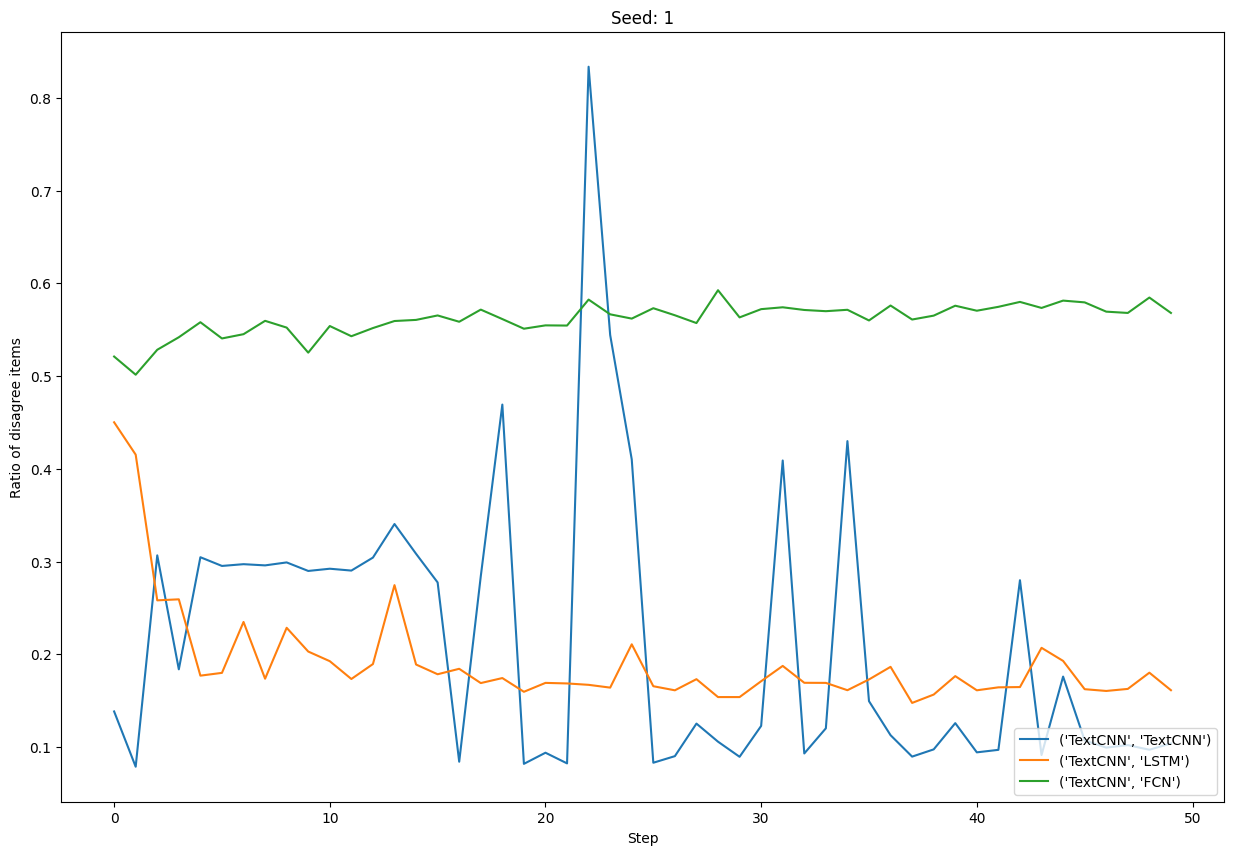

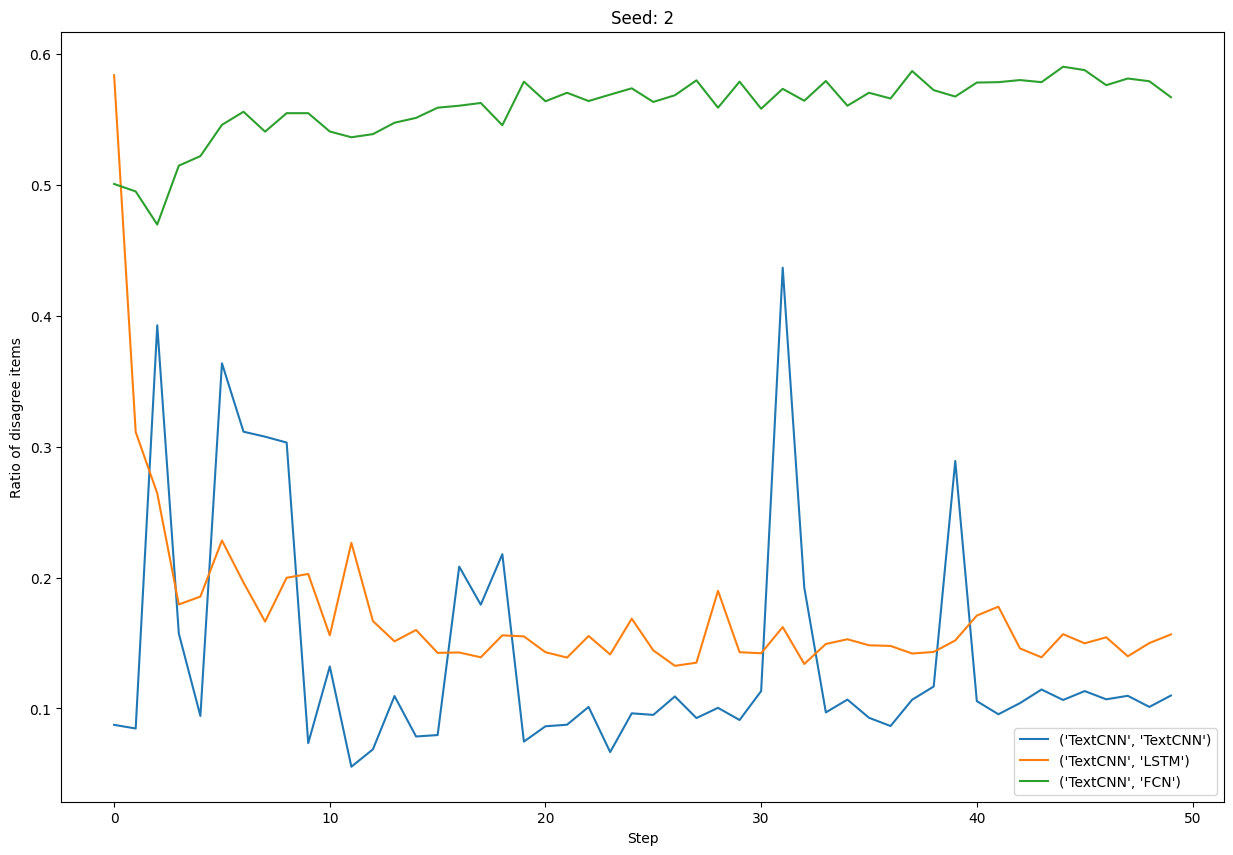

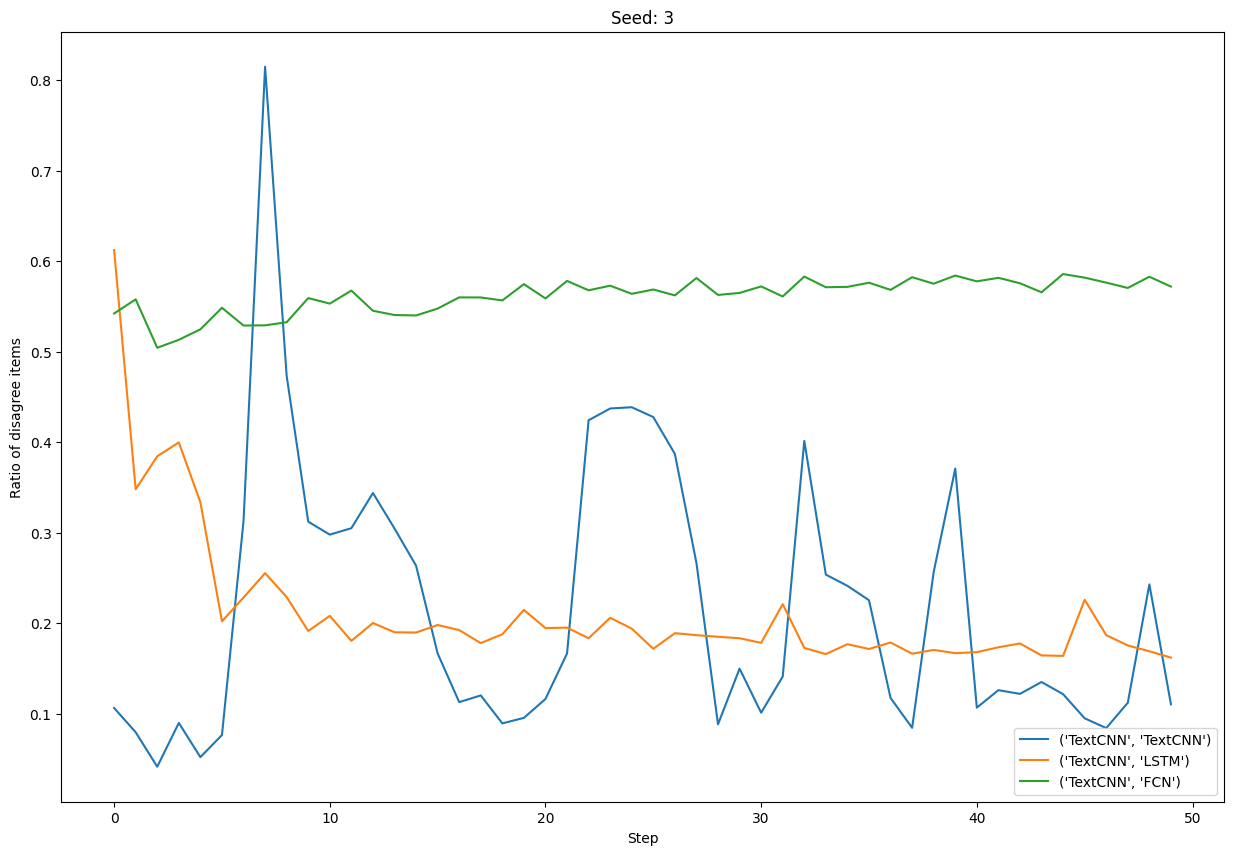

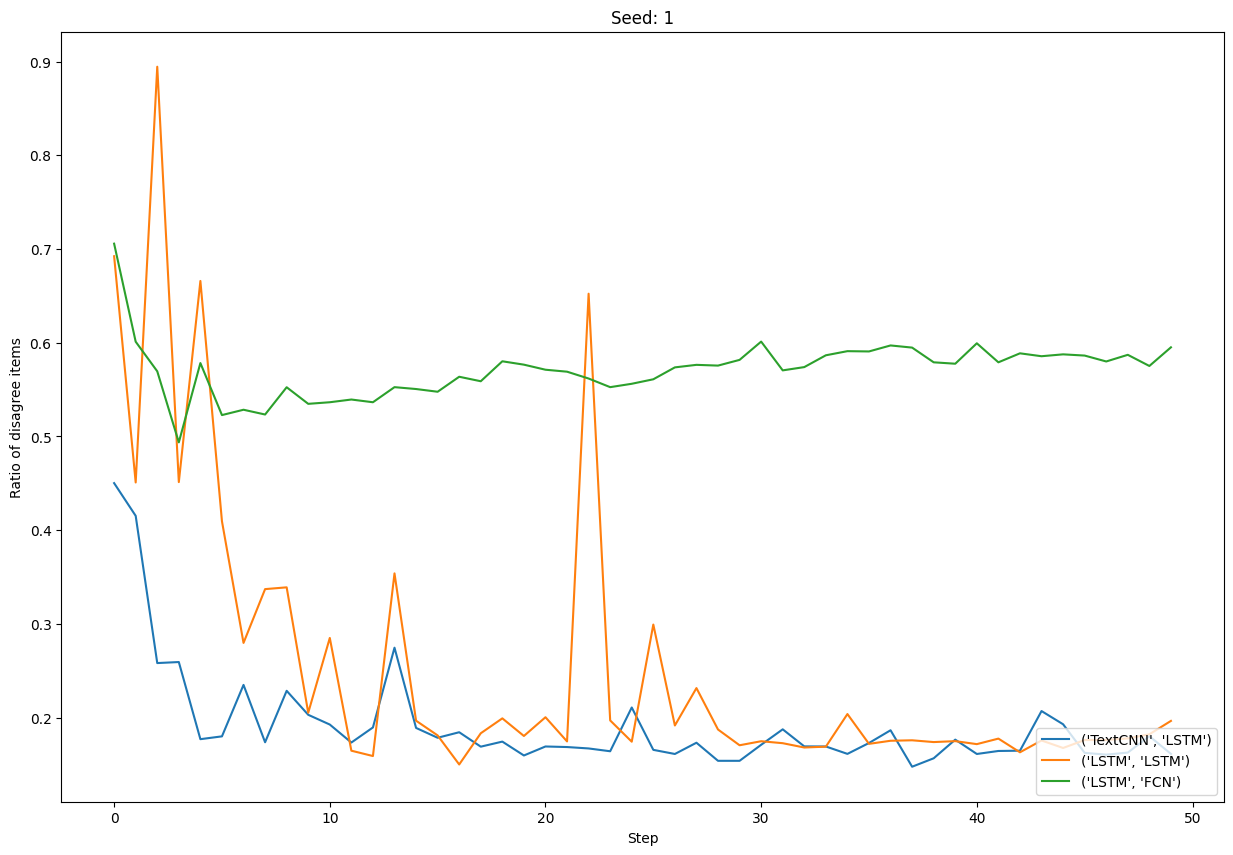

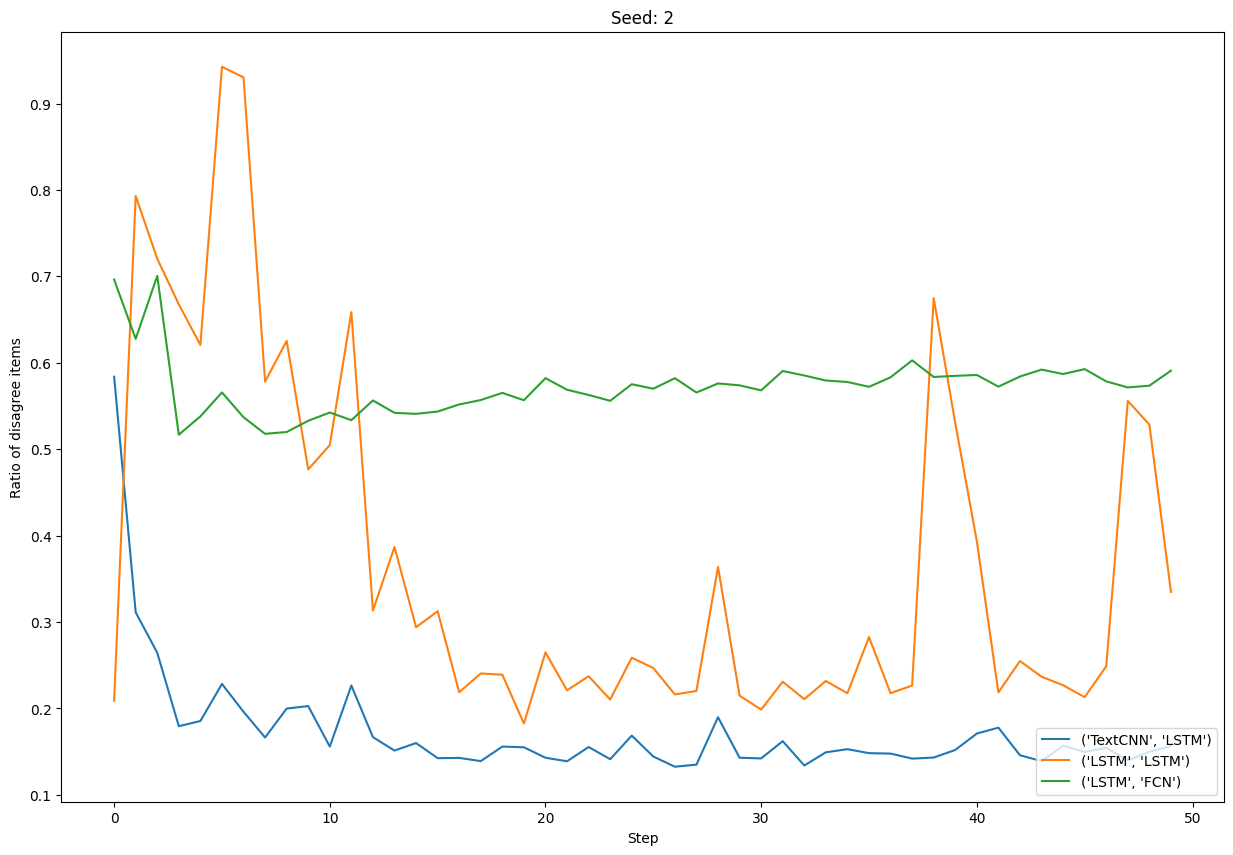

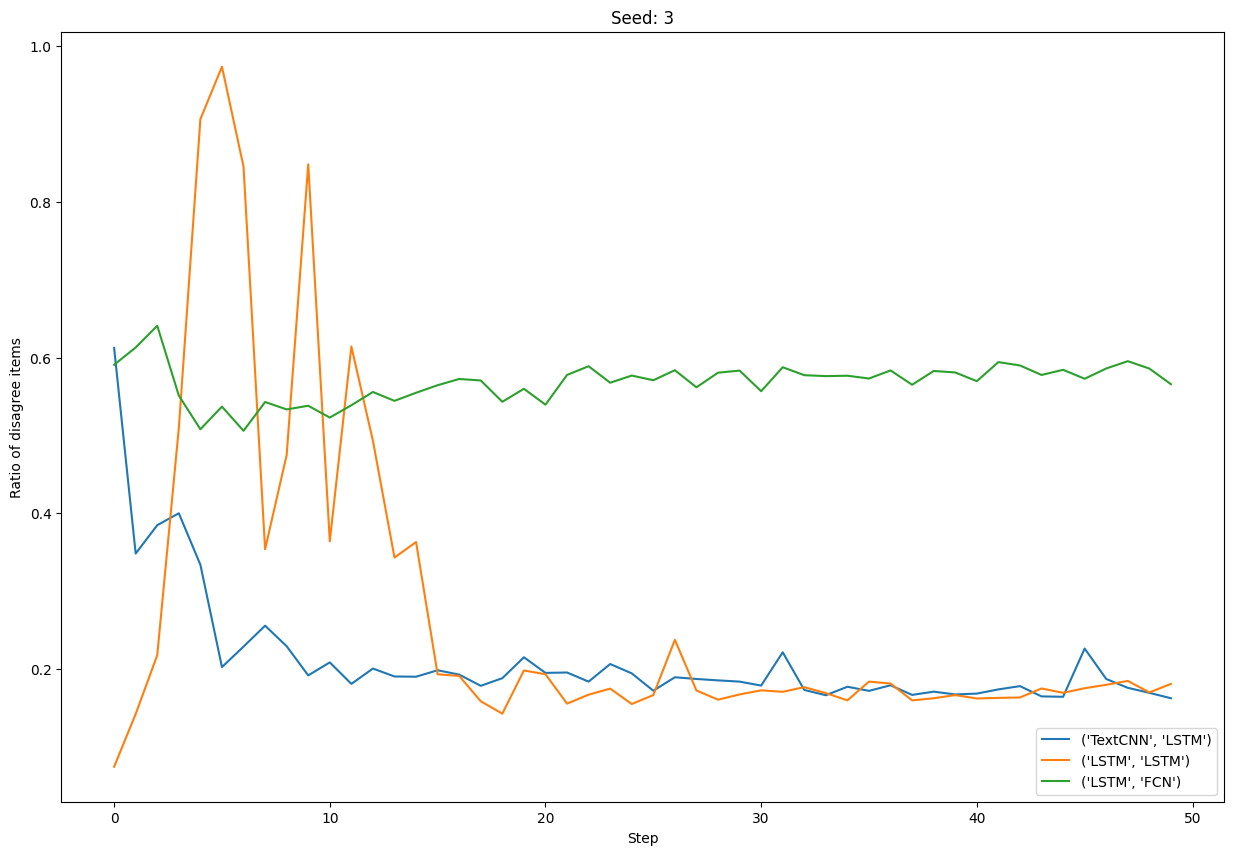

In [10]:
color = cm.rainbow(np.linspace(0, 1, 20))

def plot_disagree_trend(seed, step=50, name=None):
    if seed not in (1,2,3):
        raise ValueError

    plt.figure(figsize=(15, 10))
    plt.xlabel('Step')
    plt.ylabel('Ratio of disagree items')
    plt.title(f'Seed: {seed}')

    for i, item in enumerate(total_logs):
        if (i % 3) != (seed-1):
            continue
        if name is not None:
            if name not in item['name']:
                continue
        x = list(range(step))
        y = item['values']
        plt.plot(x, y, label=item['name'])

    plt.legend(loc='lower right')
    plt.show()
    plt.close()

plot_disagree_trend(seed=1, name='TextCNN')
plot_disagree_trend(seed=2, name='TextCNN')
plot_disagree_trend(seed=3, name='TextCNN')
plot_disagree_trend(seed=1, name='LSTM')
plot_disagree_trend(seed=2, name='LSTM')
plot_disagree_trend(seed=3, name='LSTM')

# LSTM hidden으로 비교해보기

In [11]:
logname = 'debug_20221225_lstm_dimension.log'
lstm_hidden_lst = os.path.join(path, logname)
with open(lstm_hidden_lst, "r") as f:
    lines = f.readlines()

# Building model 로그로 각 실험별로 시작 위치 잘라내기
## 먼저 Building model 로그가 위치한 point 찾아서 저장
experiment_idx_points = []
for idx, l in enumerate(lines):
    if 'Building model' in l:
        experiment_idx_points.append(idx)

## 찾아낸 Building model 로그 위치를 통해 각 실험로그를
experiment_packs = []
for idx, ex in enumerate(experiment_idx_points):
    if idx == (len(experiment_idx_points)-1):
        experiment_packs.append( lines[experiment_idx_points[idx]:] )
    else:
        experiment_packs.append( lines[experiment_idx_points[idx]:experiment_idx_points[idx+1]] )

# 구한 개별 실험마다
step_packs = []
for ex_pck in experiment_packs:
    step_indices = []
    ## step으로 나눠서 test 결과 수집하기
    for idx, line in enumerate(ex_pck):
        if "Step [109/109]" in line:
            step_indices.append(idx)

    ## 각 test 결과에서 disagree number만 뽑아내기
    lst_tot_disagree = []
    for idx, step_index in enumerate(step_indices):
        tot_disagree = 0
        for l in ex_pck[step_index+1: step_index+46]:
            number = l.split(': ')[-1]
            number = number.split('/')[0]
            number = int(number)
            tot_disagree = tot_disagree + number
        tot_disagree = tot_disagree / (128*46)
        tot_disagree = round(tot_disagree, 4)
        lst_tot_disagree.append(tot_disagree)

    step_packs.append(lst_tot_disagree)

experiments_name_list = [
    ('50', '50'), ('50', '50'), ('50', '50'),
    ('50', '100'), ('50', '100'), ('50', '100'),
    ('50', '300'), ('50', '300'), ('50', '300'),
    ('100', '100'), ('100', '100'), ('100', '100'),
    ('100', '300'), ('100', '300'), ('100', '300'),
    ('300', '300'), ('300', '300'), ('300', '300')
]

total_logs = []
for i, item in enumerate(step_packs):
    #print(f'[{experiments_name_list[i][0]:^7} / {experiments_name_list[i][1]:^7}] => {item[0:4]} ~ {item[-5:-1]}')
    print(f'[{experiments_name_list[i][0]:^7} / {experiments_name_list[i][1]:^7}] => {item}')
    temp = {'name': experiments_name_list[i], 'values': item}
    total_logs.append(temp)

[  50    /   50   ] => [0.7695, 0.6763, 0.3125, 0.4958, 0.2301, 0.1535, 0.1809, 0.1328, 0.1464, 0.2772, 0.1294, 0.1309, 0.1819, 0.3059, 0.3945, 0.178, 0.2636, 0.1586, 0.1683, 0.1603, 0.1513, 0.1554, 0.1462, 0.1489, 0.159, 0.2024, 0.1659, 0.1576, 0.1846, 0.1827, 0.1936, 0.1612, 0.1675, 0.1669, 0.1741, 0.1661, 0.1853, 0.1695, 0.1627, 0.179, 0.1478, 0.1481, 0.1695, 0.176, 0.1669, 0.1557, 0.154, 0.1627, 0.1649, 0.1637, 0.1576, 0.1579, 0.1636, 0.176, 0.1744, 0.1748, 0.1634, 0.1692, 0.1639, 0.1843]
[  50    /   50   ] => [0.3015, 0.5431, 0.3239, 0.294, 0.251, 0.2065, 0.18, 0.2208, 0.1683, 0.1773, 0.1671, 0.1902, 0.1953, 0.1542, 0.1868, 0.1641, 0.1671, 0.1619, 0.1732, 0.1656, 0.1785, 0.1724, 0.1576, 0.1625, 0.1596, 0.19, 0.1816, 0.1678, 0.1977, 0.163, 0.1641, 0.1698, 0.1776, 0.1664, 0.1668, 0.1748, 0.1751, 0.1653, 0.1688, 0.1744, 0.1605, 0.1678, 0.1663, 0.1659, 0.1722, 0.1797, 0.1766, 0.1853, 0.1889, 0.176, 0.1824, 0.1727, 0.1827, 0.1678, 0.1719, 0.1836, 0.17, 0.1776, 0.177, 0.1663]
[  50    

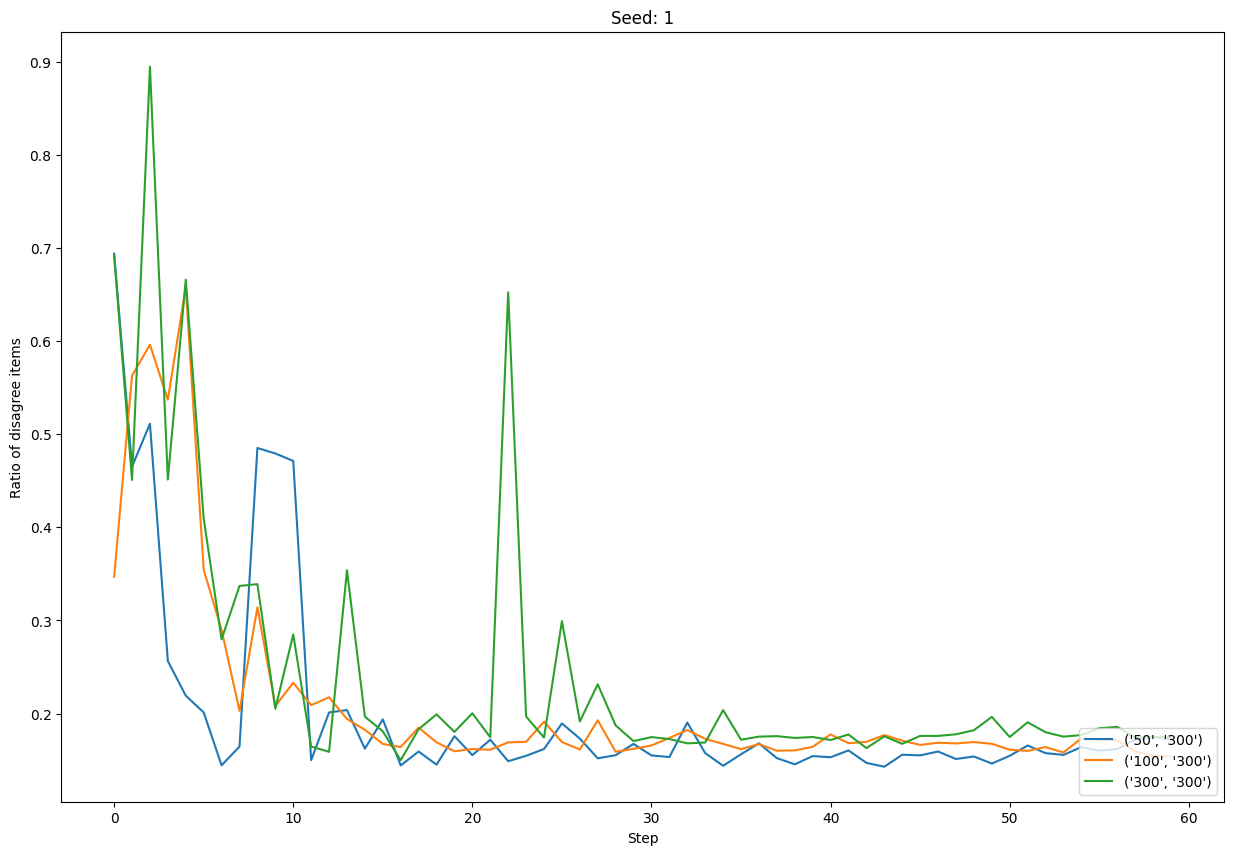

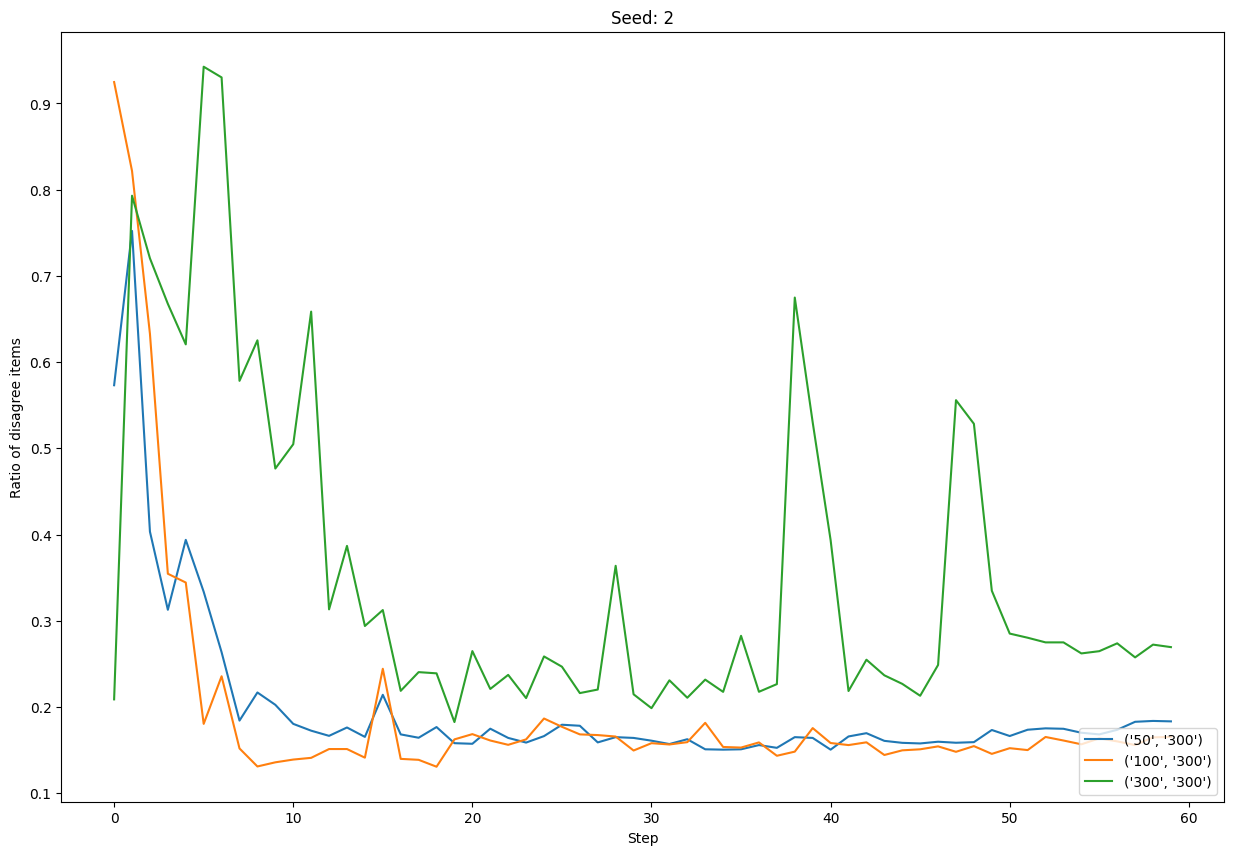

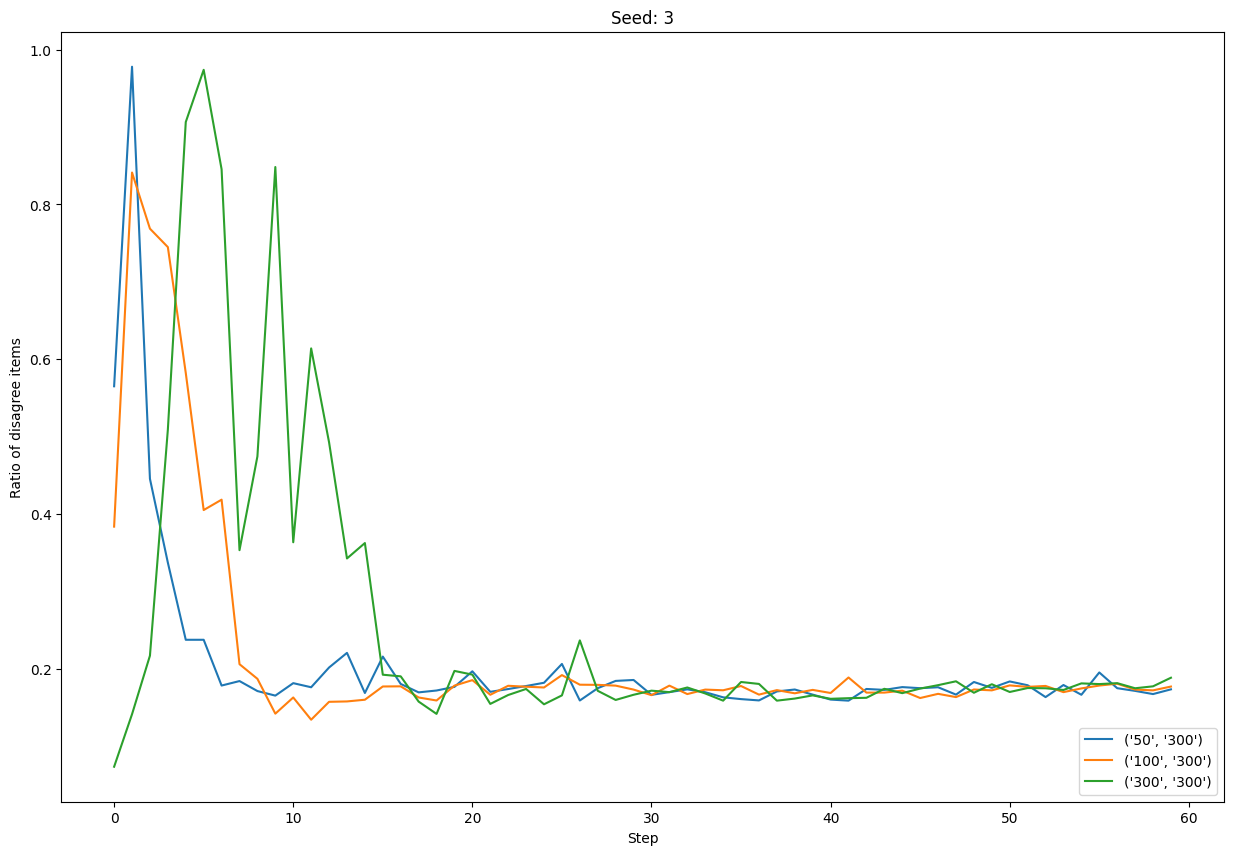

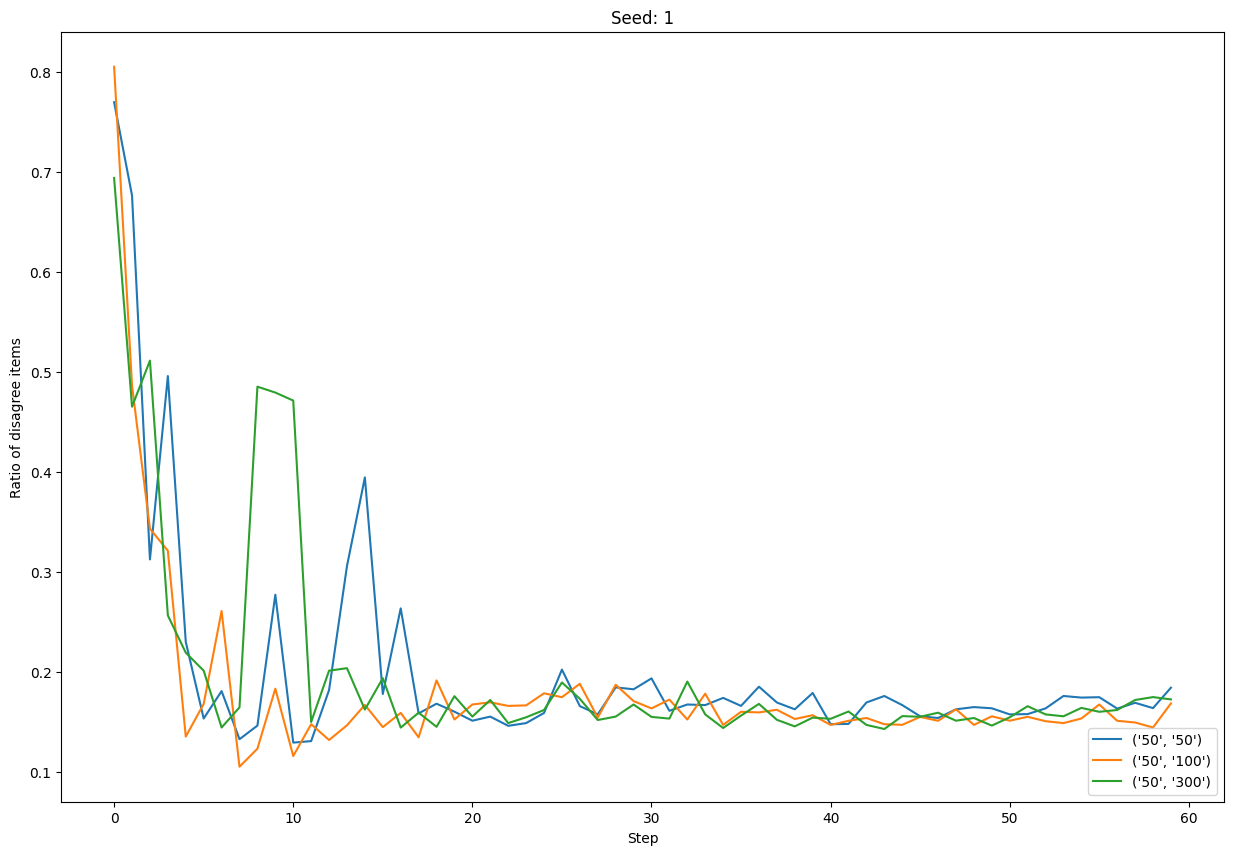

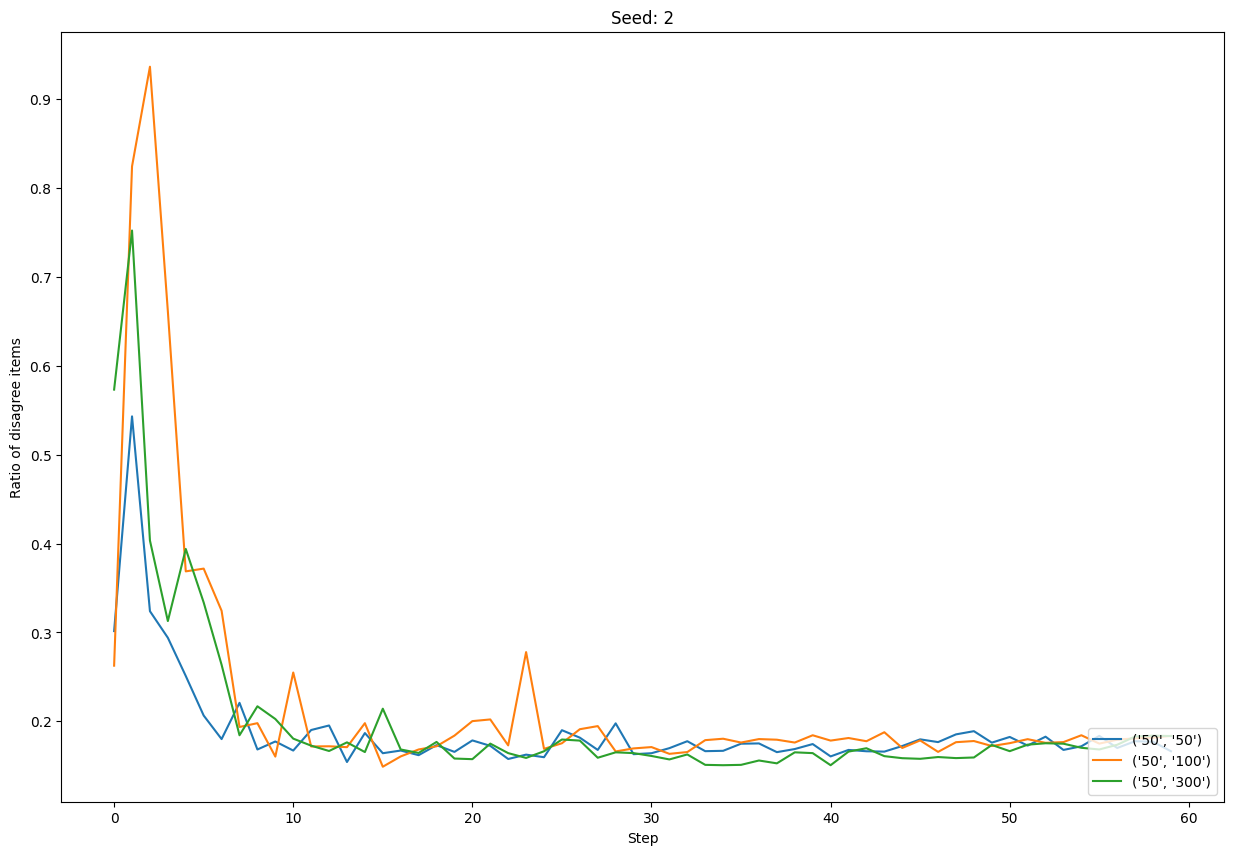

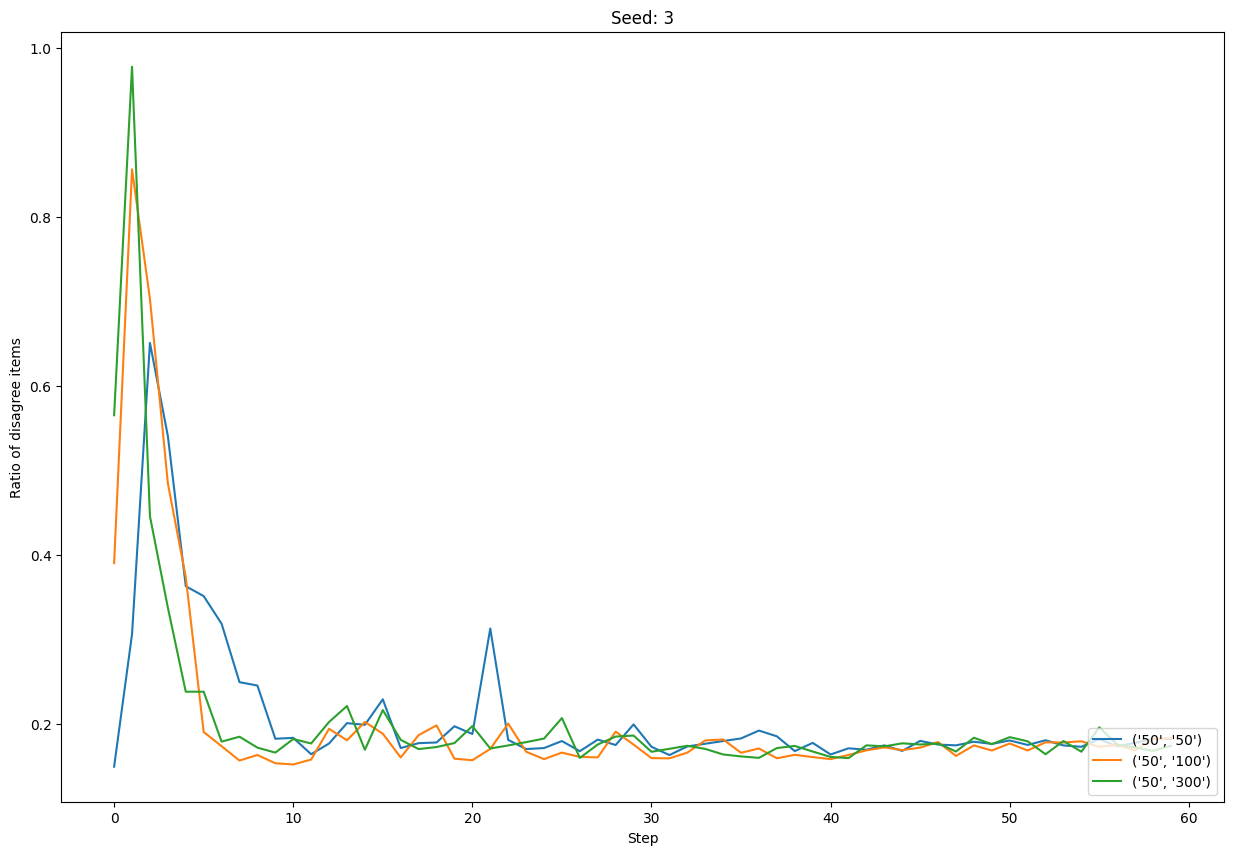

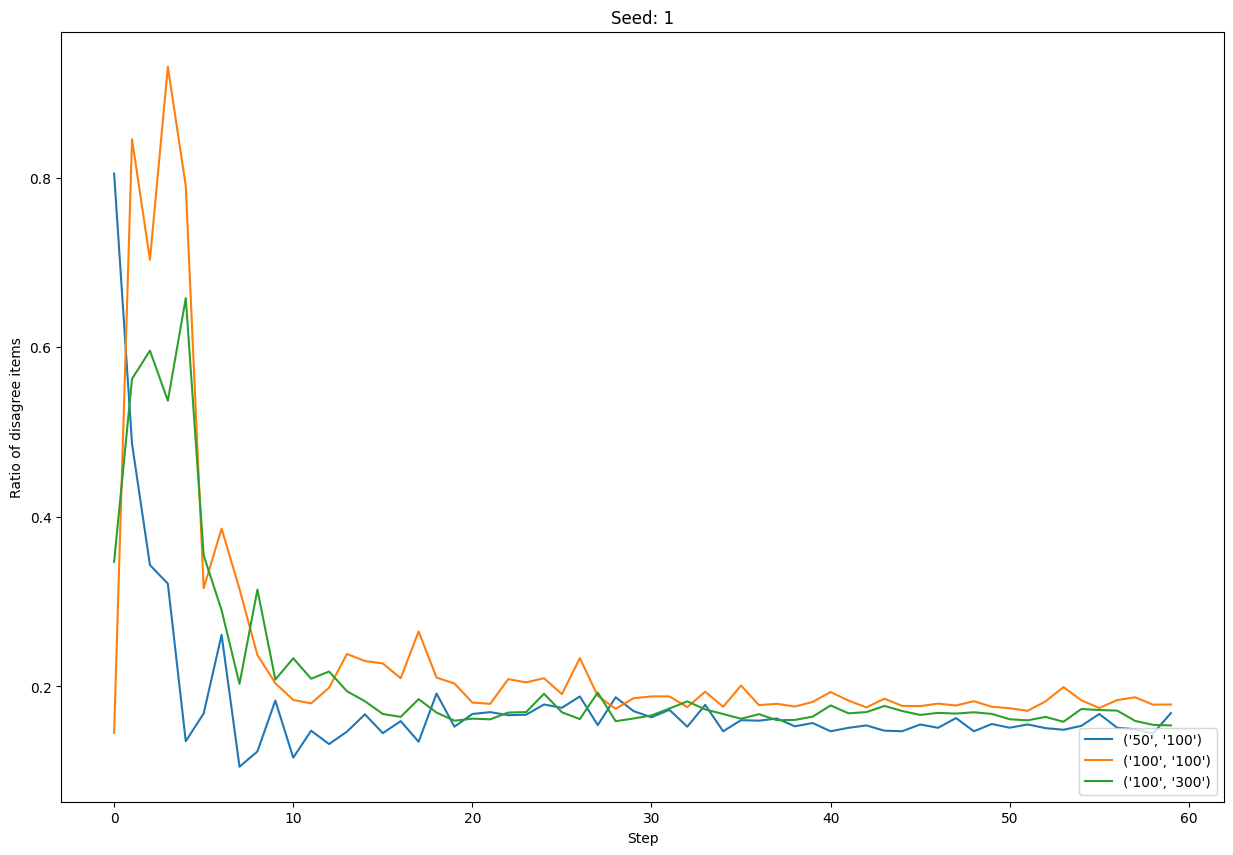

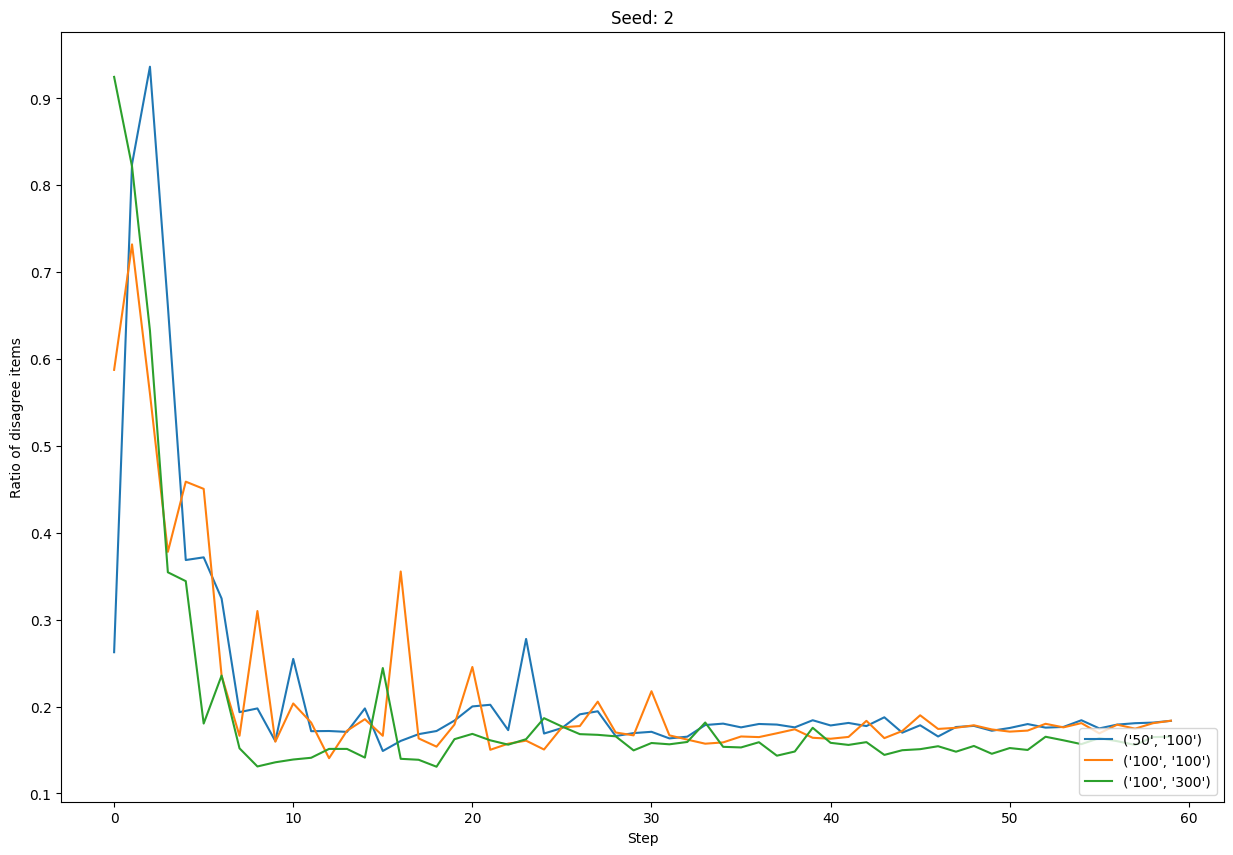

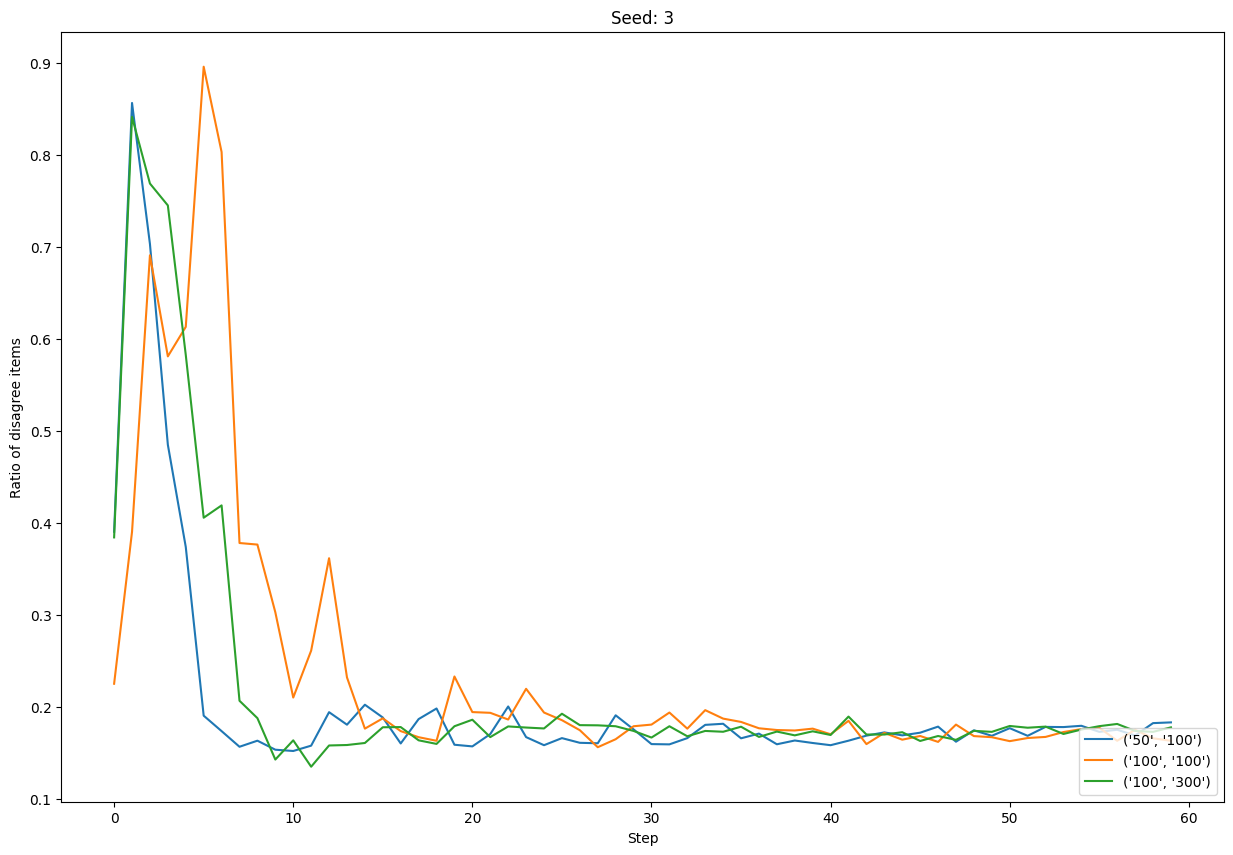

In [14]:
plot_disagree_trend(seed=1, step=60, name='300')
plot_disagree_trend(seed=2, step=60, name='300')
plot_disagree_trend(seed=3, step=60, name='300')
plot_disagree_trend(seed=1, step=60, name='50')
plot_disagree_trend(seed=2, step=60, name='50')
plot_disagree_trend(seed=3, step=60, name='50')
plot_disagree_trend(seed=1, step=60, name='100')
plot_disagree_trend(seed=2, step=60, name='100')
plot_disagree_trend(seed=3, step=60, name='100')